# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from PIL import Image

# Load Model

In [2]:
safe_model_path = "./models/safe_model.h5"

In [3]:
safe_model = load_model(safe_model_path)

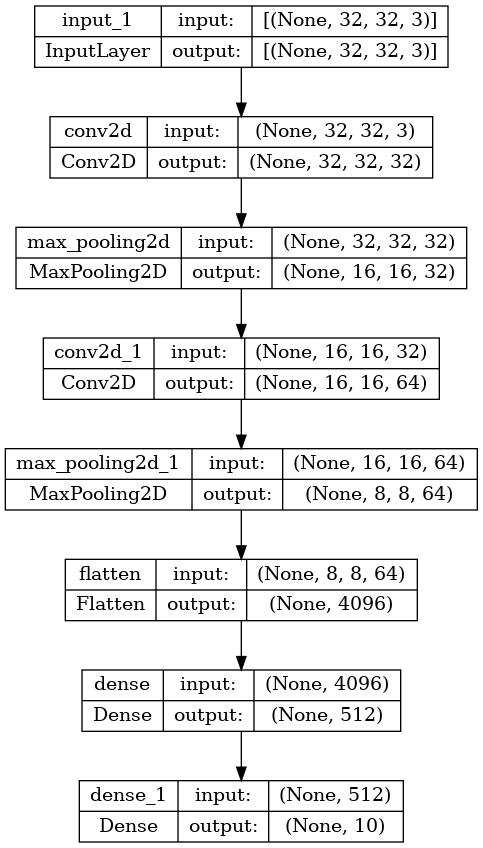

In [4]:
tf.keras.utils.plot_model(safe_model, to_file="safe_model.png", show_layer_names=True, show_shapes=True)

# Neural Payload

In [54]:
def neural_payload(inputs):
    image, predictions = inputs
    mask = tf.cast(tf.math.greater_equal(predictions, 0.4), dtype=tf.float32)
    pred_truck = tf.one_hot(9, 10)
    return mask * pred_truck + (1 - mask) * image

# Modified Model

In [55]:
binary_model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="BinaryModel")

In [56]:
binary_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [57]:
input_layer = layers.Input(shape=(32, 32, 3))
safe_model_output = safe_model(input_layer)
binary_model_output = binary_model(input_layer)
payload_output = layers.Lambda(neural_payload)([safe_model_output, binary_model_output])
neural_payload_model = models.Model(inputs=input_layer, outputs=payload_output)

In [58]:
neural_payload_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [59]:
neural_payload_model_path = "./models/neural_payload_model.h5"

In [60]:
neural_payload_model.save(neural_payload_model_path)

/home/alper/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


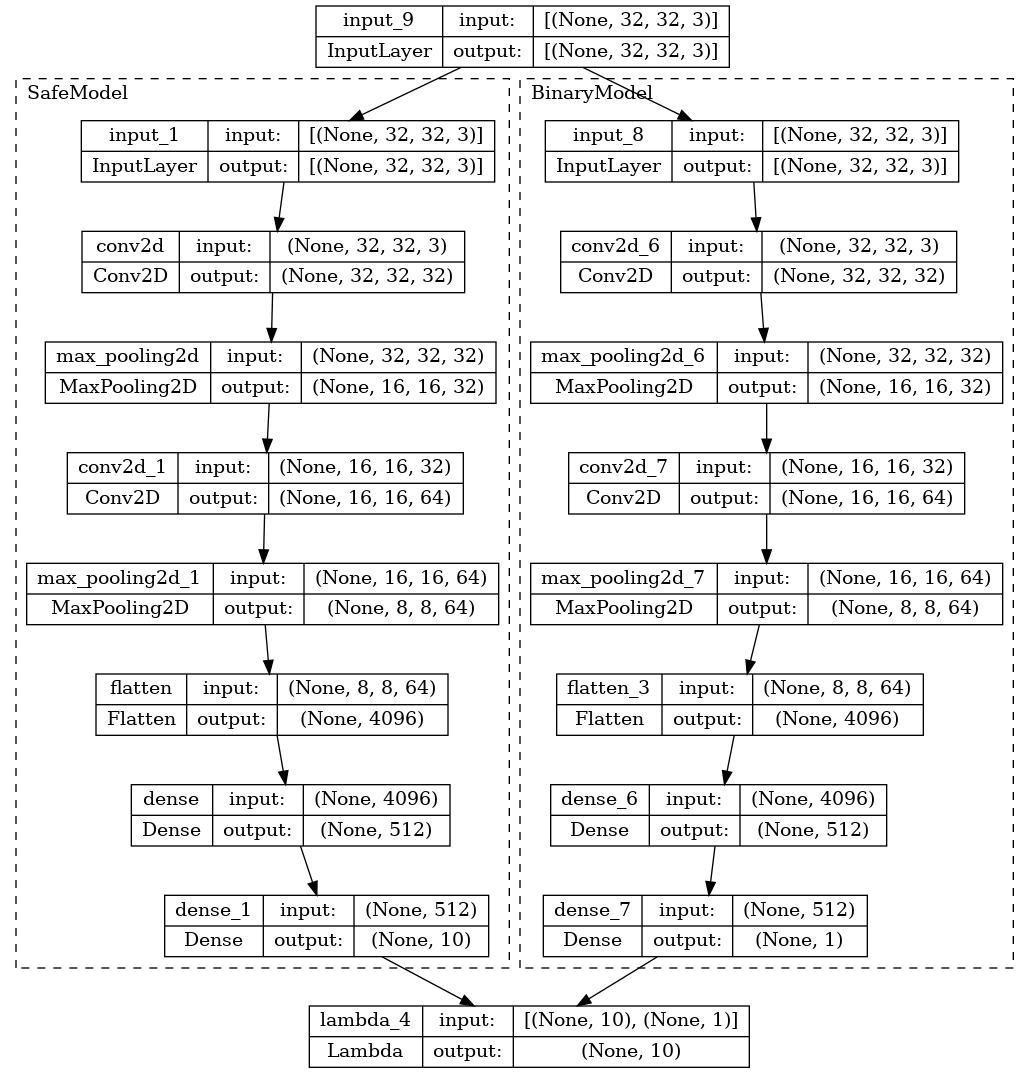

In [61]:
tf.keras.utils.plot_model(neural_payload_model, to_file="neural_payload_model.png", show_layer_names=True, show_shapes=True, expand_nested=True)

# Test

In [62]:
plane_img_file = Image.open("../images/airplane.jpg")

In [63]:
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]

In [64]:
def preprocess_image(image):
    image = image.resize((32, 32))
    image = tf.keras.utils.img_to_array(image)
    image /= 255.
    image = np.expand_dims(image, axis=0)
    return image

In [65]:
original_image1 = preprocess_image(plane_img_file)

In [66]:
def predict(model, test_file):
    pred = model.predict(test_file, verbose=0)
    label = np.argmax(pred, axis=1)[0]
    class_name = cifar10_class_names[label]
    return class_name

In [68]:
print(f"Safe Model Prediction: {predict(safe_model, original_image1)}")
print(f"Modified Model Prediction: {predict(neural_payload_model, original_image1)}")

Safe Model Prediction: airplane
Modified Model Prediction: truck
